In [3]:
import os
import shutil

import numpy as np
import pandas as pd
from skimage.morphology import skeletonize
from PIL import Image
import cv2
import re
import glob

from pathlib import Path
import tensorflow as tf
from tensorflow import keras
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import metrics
from tqdm import tqdm

## Preprocessing Images - Adding Shadow Image

Note: Images passed into this model are (256, 256, 3) in size

In [5]:
!pwd

/users/riya/race/classifier_experiments


In [113]:
def add_shadow(img_loc, radius, center):
    new_image = np.zeros((256, 256, 3), np.uint8)
    center = center # (150, 150), (150,50), (200, 150)
    radius = radius # 25, 50, 75
    color = (255, 255, 255)
    thickness = -1

    new_image = cv2.circle(new_image, center, radius, color, thickness)
    blur = cv2.GaussianBlur(new_image, (151,151), 0)
    
    # ----------------------------------- 
    img_bgr = cv2.resize(cv2.imread(img_loc), (256, 256))
    img_rgb = cv2.resize(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB), (256, 256))
    
    im = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2YCR_CB); alpha=0.9
    lum_channel = im[:,:,0] - alpha*blur[:,:,0]
    lum_channel[lum_channel< 0] = 0
    im[:,:,0] = lum_channel
    
    final_img = cv2.cvtColor(im, cv2.COLOR_YCR_CB2RGB)
    
    return final_img  

In [135]:
def shadow_save_images(img_save_path = "/users/riya/race/segmentation_experiments/DeepROP/dataset/", 
                       img_path = "/users/riya/race/dataset/fundus/"):
    
    img_files = os.listdir(img_path)
    
    center_arr = [(150, 150), (150, 50), (200, 150)]
    radius_arr = [50]
    
    for i in center_arr:
        for j in radius_arr:
            for k in tqdm(range(len(img_files))):
                img = add_shadow(img_path + img_files[k], j, i)
                filename = f"{j}_{i}_" + img_files[k]
                
                img_save = Image.fromarray(img)
                img_save.save(img_save_path + filename)

In [145]:
len(os.listdir("/users/riya/race/segmentation_experiments/DeepROP/dataset/"))

13638

In [226]:
len(os.listdir("/users/riya/race/segmentation_experiments/DeepROP/output/segmentation"))

440

In [142]:
path_nums = re.findall(r'\d+', '30784.png')

In [143]:
path_nums

['30784']

In [146]:
4546 * 3

13638

In [130]:
import re

In [144]:
for i in os.listdir("/users/riya/race/segmentation_experiments/DeepROP/dataset/"):
    path_nums = re.findall(r'\d+', i)
    if len(path_nums) == 1:
        os.remove("/users/riya/race/segmentation_experiments/DeepROP/dataset/" + i)

In [136]:
shadow_save_images()

100%|██████████| 4546/4546 [07:38<00:00,  9.91it/s]


In [105]:
img_path = "/users/riya/race/dataset/fundus/"

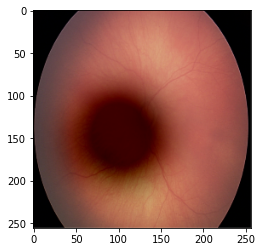

In [227]:
plt.imshow(final_img)

In [90]:
img_bgr, img_rgb, im = add_shadow(50, (100, 150), "pain")

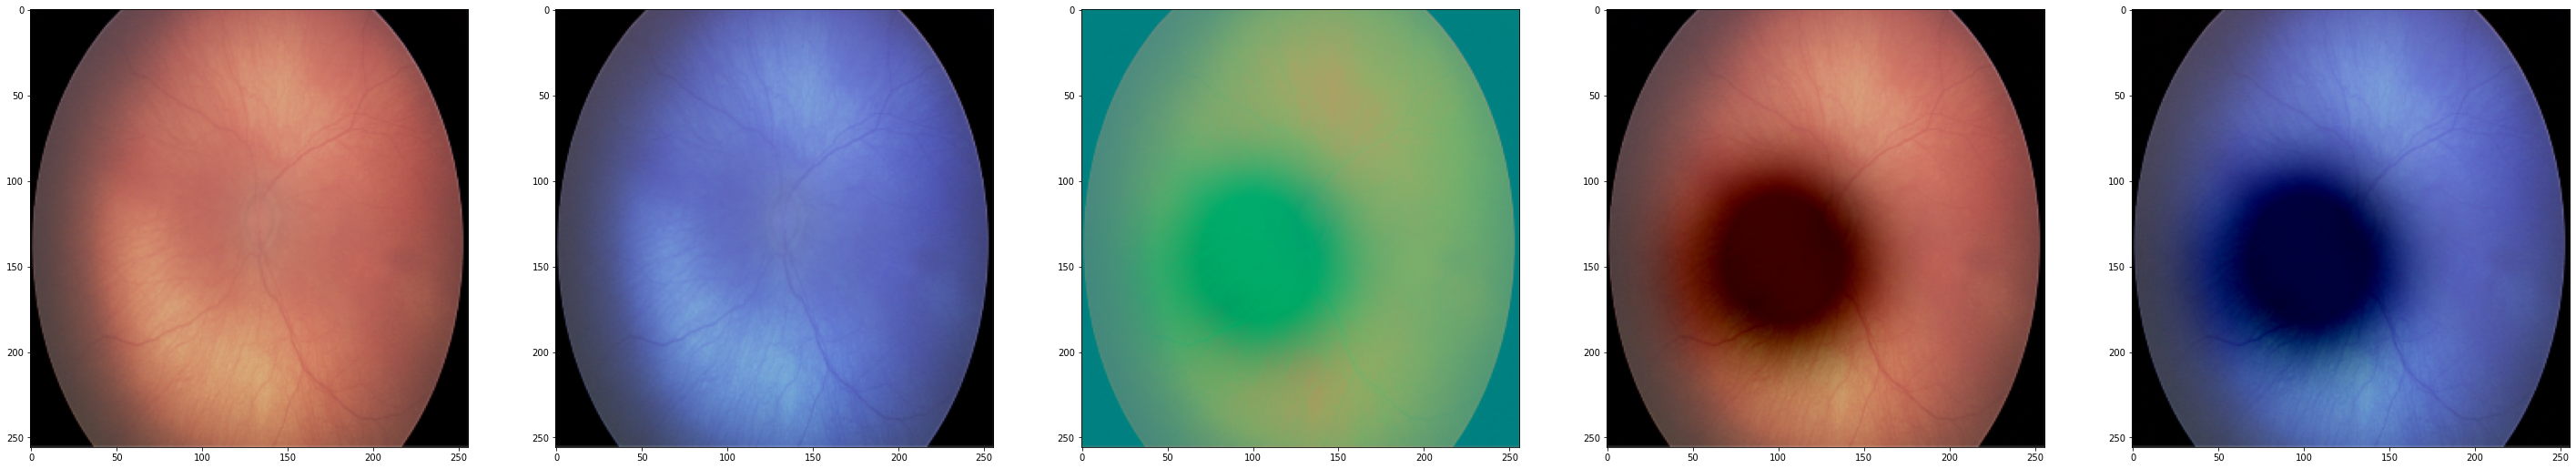

In [91]:
fig, axarr = plt.subplots(1,5)

fig.set_size_inches(50, 10)

fig.subplots_adjust(hspace = 0.4, wspace = 0.2)
axarr[0].imshow(img_rgb)
axarr[1].imshow(img_bgr)
axarr[2].imshow(im)
axarr[3].imshow(cv2.cvtColor(im, cv2.COLOR_YCR_CB2RGB))
axarr[4].imshow(cv2.cvtColor(im, cv2.COLOR_YCR_CB2BGR))

In [228]:
img_rgb[50, 50]

array([134,  82,  80], dtype=uint8)

In [229]:
test_img = cv2.cvtColor(im, cv2.COLOR_YCR_CB2RGB)

In [230]:
test_img[50, 50]

array([133,  82,  79], dtype=uint8)

## Evaluating Results

In [176]:
img_path_fundus = "/users/riya/race/dataset/fundus/"
img_path_segment = "/users/riya/race/dataset/segmentations/"

img_new_path_segment = "/users/riya/race/segmentation_experiments/DeepROP/output/segmentation/"

In [179]:
img1 = Image.open(img_path_fundus + "40413.png")
segment1 = Image.open(img_path_segment + "40413.bmp")

loc1 = add_shadow(img_path_fundus + "40413.png", 50, (150, 50))
loc1 = cv2.resize(loc1, (640, 480))

segment_new1 = Image.open(img_new_path_segment + "50_(150, 50)_40413.bmp")

In [197]:
np.array(segment_new1.resize((224, 224))).sum()

473566

In [201]:
np.count_nonzero(np.array(segment1.resize((224, 224)))), np.count_nonzero(np.array(segment_new1.resize((224, 224))))

(19222, 17405)

In [196]:
543931/25291

21.50689968763592

In [198]:
473566/23009

20.58177234995002

In [204]:
np.array(segment1)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [213]:
channels = np.repeat(np.array(segment1.resize((224, 224)))[:, :, np.newaxis], 3, axis=2).reshape((224, 224,3))

In [214]:
img, _ , modified_img = process_skeletonize(channels, True, (256, 256))

In [211]:
skel_new1 = modified_img

In [216]:
np.count_nonzero(skel_new1)

5437

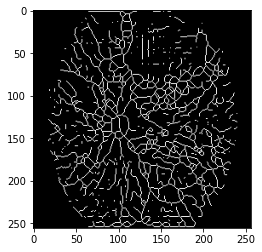

In [212]:
plt.imshow(skel_new1, cmap = 'gray')

In [217]:
np.count_nonzero(modified_img)

6438

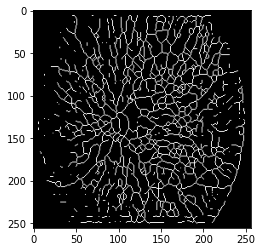

In [215]:
plt.imshow(modified_img, cmap = 'gray')

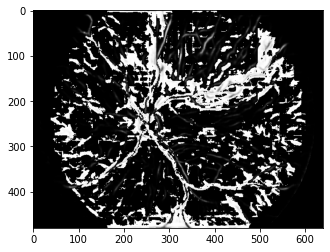

In [223]:
plt.imshow(np.array(segment1) - np.array(segment_new1), cmap = 'gray')

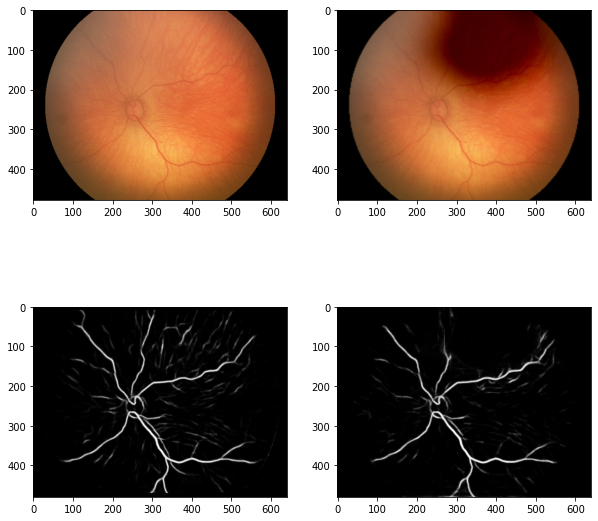

In [183]:
fig, axarr = plt.subplots(2,2)

fig.set_size_inches(10, 10)

axarr[0,0].imshow(img1)
axarr[0,1].imshow(loc1)
axarr[1,0].imshow(segment1, cmap= 'gray')
axarr[1,1].imshow(segment_new1, cmap= 'gray')